# Туториал по двухэтапной модели

In [1]:
import datetime
import dill
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import pyarrow.parquet as pq
from zipfile import ZipFile
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import warnings
warnings.simplefilter('ignore')
import gc


pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 20)

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type to reduce memory usage.
    """
    
#     N = df.user_id.nunique()
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    cs = [i for i in df.columns if i not in ['user_id', 'item_id']]
    for col in cs:
        col_type = df[col].dtype.name

        if col_type not in ['object', 'category', 'datetime64[ns, UTC]']:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

#     assert N == df.user_id.nunique()
    return df

# users = reduce_mem_usage(users)

## Загрузим данные

# 🎛 EDA

## `interactions`: взаимодействия пользователь - айтем 
- с датой `last_watch_dt`
- длительностью просмотра `total_dur`
- % просмотра `watched_pct`

# Агрегация и фильтрация кластеров

Уберем повторы, будет считать что продукт это фильм, просмотренный раз

In [3]:
def get_interactions():
    
    try:
        interactions = pd.read_csv('../input/stage-1/interactions.csv')
        
    except:
        interactions = pd.read_csv('../input/hack-the-cart/hist_data.csv')
        interactions.rename(columns={'buyer_id': 'user_id',
                                     'count' : 'product_quantity', 'created' : 'completed_at'} , inplace=True)
        nes_cols = ['user_id', 'item_id', 'completed_at','product_quantity']
        interactions = interactions[nes_cols].groupby(['user_id', 'item_id'], as_index=False).agg({'completed_at' : 'max', 
                                                                                       'product_quantity': 'sum'})

    interactions['user_id'] = interactions.user_id.astype(int)
    interactions['item_id'] = interactions.item_id.astype(int)
    
    return interactions
    
interactions = get_interactions()

In [4]:
interactions['completed_at'] = pd.to_datetime(interactions['completed_at'], infer_datetime_format=True)

max_date = interactions['completed_at'].max()
min_date = interactions['completed_at'].min()

print(f"min дата в interactions: {min_date}")
print(f"max дата в interactions: {max_date}")

min дата в interactions: 2021-07-01 00:03:44
max дата в interactions: 2021-09-07 18:48:29


In [5]:
import gc

gc.collect()

21

# ✂️ Схема валидации

## Глобальный train - test

На `test` будем проверять результат обоих моделей:
-  отдельно модели 1го уровня: LightFM
- отдельно двухуровненой модели: LightFM + Catboost

На test оставим 7 дней

In [6]:
train = interactions[(interactions['completed_at'] < max_date - pd.Timedelta(days=7))]
print('Трейн готов')
test = interactions[(interactions['completed_at'] >= max_date - pd.Timedelta(days=7))]

# дополнительная фильтрация train для исключения случайных просмотров 
# train = train[train['total_dur'] >= 300]

del interactions, max_date
print(f"train: {train.shape}")
print(f"test: {test.shape}")

Трейн готов
train: (3541790, 5)
test: (102376, 5)


# 1️⃣ 1 этап: LightFM

- обучаем LightFM user2item модель на LighFM train

- делаем предикт c кандидатами на LighFM predict



## Разделим данные для LightFM еще на 2 части

### train + pred for candidates 

Разделим данные на `lfm_train` и `lfm_pred` как 60%-40% по квантилю даты просмотра 

(Считаем, что гиперпараметры оптимальной lfm модели мы уже подобрали)

На `lfm_pred` будем в дальнейшем обучать бустинг - модель 2 этапа

In [7]:
lfm_date_threshold = train['completed_at'].quantile(q=0.75, interpolation='nearest')

print(lfm_date_threshold)

lfm_train = train[(train['completed_at'] < lfm_date_threshold)]
lfm_pred = train[(train['completed_at'] >= lfm_date_threshold)]

del train, lfm_date_threshold
gc.collect()
# print(f"lfm_train: {lfm_train.shape}")
# print(f"lfm_pred: {lfm_pred.shape}")

2021-08-16 09:20:44


42

Будем предсказывать кандидатов только на теплых пользователях - у которых есть просмотры в обучающей выборке

In [8]:
lfm_pred = lfm_pred[lfm_pred['user_id'].isin(lfm_train['user_id'].unique())]
lfm_pred.drop(['product_quantity'], inplace=True, axis=1)
lfm_pred.drop_duplicates(inplace=True)


lfm_train.drop(['product_quantity'], inplace=True, axis=1)
lfm_train.drop_duplicates(inplace=True)

In [9]:
lfm_train.head(3)

,Unnamed: 0,user_id,item_id,completed_at
0,0,94578442,202795926,2021-08-08 09:58:03
1,1,94578442,202801709,2021-08-08 09:58:03
2,2,94578442,202806979,2021-07-15 17:37:29


## Обучение LightFM

In [10]:
import dill as pickle
# lfm_model = pickle.load('../input/stage-1-lightfm-mts-course/lfm_model.dill')


with open('../input/stage-1/lfm_model.dill', 'rb') as pickle_file:
    lfm_model = pickle.load(pickle_file)
    
    
with open('../input/stage-1/data.pkl', 'rb') as pickle_file:
    lightfm_mapping = pickle.load(pickle_file)

## Генерируем предсказания LightFM как кандидатов для второго этапа

### В `tools` вынесены функции из лекций первого курса Your First Recsys  <a href="https://www.kaggle.com/sharthz23/implicit-lightfm">Код лекций</a>

`generate_lightfm_recs_mapper` - функция для генерации LightFM предсказаний по всем пользователям с учетом удаления просмотренных айтемов

`compute_metrics` - функция для расчета классических метрик для рекомендаций (будем использовать в конце)

In [11]:
def generate_lightfm_recs_mapper(model, item_ids, known_items, user_features, item_features, N, user_mapping, item_inv_mapping, num_threads=4):
    def _recs_mapper(user):
        user_id = user_mapping[user]
        recs = model.predict(user_id, item_ids, user_features=user_features, item_features=item_features, num_threads=num_threads)
        
        additional_N = len(known_items[user_id]) if user_id in known_items else 0
        total_N = N + additional_N
        top_cols = np.argpartition(recs, -np.arange(total_N))[-total_N:][::-1]
        
        final_recs = [item_inv_mapping[item] for item in top_cols]
        if additional_N > 0:
            filter_items = known_items[user_id]
            final_recs = [item for item in final_recs if item not in filter_items]
        return final_recs[:N]
    return _recs_mapper

In [12]:
# # кол-во кандидатов 
# top_N = 20 # тут сколько хочешь 

# # вспомогательные данные 
all_cols = list(lightfm_mapping['items_mapping'].values())

# 2️⃣ 2 этап: обучаем бустинг (`CatBoost`) 

- Ставим задачу как бинарную классификацию
- Выбираем `CatBoostClassifier`, так как много категориальных признаков 

##  Собираем train + target

### 📗 `target = 1` Позитивные взаимодействия = все что пользователь посмотрел из кандидатов lightfm 

In [13]:
lfm_pred.head()

,Unnamed: 0,user_id,item_id,completed_at
126,126,94578595,202802094,2021-08-17 12:19:39
128,128,94578595,202806977,2021-08-17 12:19:39
129,129,94578595,202807167,2021-08-17 12:19:39
130,130,94578595,202807477,2021-08-17 12:19:39
132,132,94578595,202864758,2021-08-17 12:19:39


### 📕 `target = 0` Негативные взаимодействия = все что пользователь НЕ посмотрел из кандидатов lightfm 

- добавим сэмплирование, чтобы соблюсти баланс классов

In [14]:
def make_dataset(max_rank = 55):
    
    # Позитивные
    
    candidates = pd.read_csv('../input/stage-1/candidates_stage_1.csv')
    candidates = reduce_mem_usage(candidates)
    candidates = candidates[candidates['rank'] <= max_rank]
    
    pos = candidates.merge(lfm_pred,
                        on=['user_id', 'item_id'],
                        how='inner')
    pos['target'] = 1
    print(pos.shape)
    pos.drop(['completed_at'], axis=1, inplace=True)
    pos.head()

    # Негативные

    gc.collect()  # Тут по памяти иногда не проходит

    neg = candidates.sample(frac=0.9).set_index(['user_id', 'item_id'])\
        .join(lfm_pred.set_index(['user_id', 'item_id']))


    neg = neg[neg['completed_at'].isnull()].reset_index()
#     neg = neg.sample(frac=0.7)
    neg['target'] = 0
    neg.shape

    gc.collect()
    
    return neg, pos


neg, pos = make_dataset(max_rank = 120)

Memory usage of dataframe is 180.17 MB
Memory usage after optimization is: 135.13 MB
Decreased by 25.0%
(161824, 6)


## Формируем трейн и тест: ctb_train, ctb_test

### Важно! Делим по пользователям, а не по дате. 

`Мотивация`: 

- Для негативных взаимодействий нет даты
- Проверяем робастность бустинга относительно новых (холодных) пользователей

In [15]:
def make_splits():
    global lfm_pred, pos, neg
#     neg, pos = make_dataset()
    
    ctb_train_users, ctb_test_users = train_test_split(lfm_pred['user_id'].unique(),
                                                      random_state=1,
                                                      test_size=0.2)

#     del lfm_pred
    gc.collect()

    # выделяем 10% под механизм early stopping
    ctb_train_users, ctb_eval_users = train_test_split(ctb_train_users,
                                                      random_state=1,
                                                      test_size=0.1)

    select_col = ['user_id', 'item_id', 'rank', 'target']

    # Catboost train
    ctb_train = shuffle(
        pd.concat([
            pos[pos['user_id'].isin(ctb_train_users)],
            neg[neg['user_id'].isin(ctb_train_users)]
    ])[select_col]
    )

    # Catboost test
    ctb_test = shuffle(
        pd.concat([
            pos[pos['user_id'].isin(ctb_test_users)],
            neg[neg['user_id'].isin(ctb_test_users)]
    ])[select_col]
    )

    # for early stopping
    ctb_eval = shuffle(
        pd.concat([
            pos[pos['user_id'].isin(ctb_eval_users)],
            neg[neg['user_id'].isin(ctb_eval_users)]
    ])[select_col]
    )

    del neg, pos
    del ctb_test_users, ctb_eval_users, ctb_train_users
    
    return select_col, ctb_train, ctb_test, ctb_eval

select_col, ctb_train, ctb_test, ctb_eval = make_splits()

### Проверяем баланс классов

In [16]:
ctb_train['target'].value_counts(normalize=True)

0    0.937592
1    0.062408
Name: target, dtype: float64

In [17]:
ctb_test['target'].value_counts(normalize=True)

0    0.936871
1    0.063129
Name: target, dtype: float64

## Формируем фичи 

- в этом ноутбуке рассмотрен бейзлайн с минимальной обработкой признаков - оставляем ее для Catboost
- выбираем простые категориальные признаки, которые не нужно предобрабатывать
- как признак также используем `rank` от модели 1 этапа
- заполняем пропуски в данных

## `users`: данные о пользователях

- `age` бин по возрасту 
- `income` бин по доходу 
- `sex` пол 
- `kids_flg` флаг наличия детей

Все признаки - результат предсказания соцдем моделей

In [18]:
def get_user():
    users = pd.read_csv('../input/feature-eng/user_features.csv').drop_duplicates()
    users.rename(columns={'buyer_id': 'user_id'} , inplace=True)
    print(users.user_id.nunique())
    users = reduce_mem_usage(users)
    return users
    
users = get_user()  

 
gc.collect()
users.head()


63925
Memory usage of dataframe is 11.34 MB
Memory usage after optimization is: 5.00 MB
Decreased by 55.9%


,user_id,median_total_cost_user,mean_total_cost_user,std_total_cost_user,median_price_sold_user,mean_price_sold_hist_user,std_price_sold_user,the_most_expensive_purchase_user,the_most_expensive_user,favorite_day_user,favorite_item_user,is_day_most_flag_user,is_weekend_most_flag_user,median_buy_hour_user,buy_range_user,number_of_unique_items_user,number_of_unique_visits_user,item_in_orders_user,mean_order_per_week,second_favorite_item_user,third_favorite_item_user,fourth_favorite_item_user,fifth_favorite_item_user,zero_price_orders
0,94578442,134.0000,152.7500,100.008995,95.0000,128.3750,109.095589,393.989990,419.993988,6,202801709,1.0,1.0,17.0,392.933990,31,3,37,12.335938,202979560,203438161,203529348,203457496,0.0
1,94578475,96.9375,142.5000,159.480331,71.4375,118.3750,145.519043,848.989990,848.989990,5,202791192,1.0,1.0,15.0,820.494995,38,2,38,19.000000,203083929,203011581,203566429,202880254,0.0
2,94578533,74.0000,104.8125,100.222633,54.0000,78.9375,75.936279,599.979980,337.989990,4,202807066,1.0,0.0,12.0,335.500000,54,4,62,20.671875,202864758,202915968,203586026,202872237,0.0
3,94578595,127.5000,216.6250,296.156799,100.0000,127.0000,78.101074,1803.732056,363.987000,1,202799674,1.0,0.0,12.0,350.041992,36,3,43,14.335938,202807477,202799674,202801849,202806977,0.0
4,94578656,69.9375,93.8750,70.958069,64.1250,84.1250,63.949863,335.489990,335.489990,1,202838754,1.0,0.0,16.0,321.644989,63,6,80,16.000000,202872237,202820148,202910396,202807411,0.0


## `items`: данные об айтемах

- `content_type` - тип контента
- `title` - название на русском
- `title_orig` - название оригинальное

In [19]:
def get_item():
    items = pd.read_csv('../input/feature-eng/item_features.csv').drop_duplicates()
    print(items.item_id.nunique())
    items = reduce_mem_usage(items)
    return items
    
items = get_item()  
gc.collect()

items.head()


52472
Memory usage of dataframe is 8.11 MB
Memory usage after optimization is: 3.00 MB
Decreased by 63.0%


,item_id,favorite_day_items,is_day_most_flag_items,std_total_cost_user,median_price_sold_items,mean_price_sold_hist_items,std_price_sold_items,median_amout_items,mean_amout_items,max_amout_items,range_amout_items,percentage_in_orders_items,is_weekend_most_flag_items,item_cost_defference_from_median,median_buy_hour_items,price_s_mean_items,price_s_median_items,item_bought_count_items,price_s_max_min,mean_count,zero_price_sold_count
0,202782406,6,1.0,26.963274,14.992188,12.546875,3.501953,2.0,2.0,20.0,19.0,0.000359,0.0,-89.625000,13.0,12.546875,14.992188,83,48.6875,1.272461,0.0
1,202782407,2,1.0,0.000000,150.000000,150.000000,0.000000,1.0,1.0,1.0,0.0,0.000004,0.0,45.343750,16.0,150.000000,150.000000,1,451.5000,0.840820,0.0
2,202782412,4,1.0,299.000000,299.000000,299.000000,0.000000,2.0,2.0,3.0,2.0,0.000013,1.0,194.375000,11.0,299.000000,299.000000,3,70.0000,2.140625,0.0
3,202782414,5,1.0,34.013023,90.000000,90.000000,0.000000,1.0,1.0,2.0,1.0,0.000030,0.0,-14.656250,15.0,90.000000,90.000000,7,500.0000,1.026367,0.0
4,202782415,3,1.0,46.613556,104.625000,109.437500,29.937500,1.0,1.0,3.0,2.0,0.000078,0.0,-0.033722,12.0,109.437500,104.625000,18,190.5000,1.040039,0.0


In [20]:
user_col = [i for i in users.columns]
item_col = [i for i in items.columns]

In [21]:
# ctb_train['user_id'] = ctb_train.user_id.astype(int)
# ctb_train.sample(frac=0.1).merge(users[user_col].drop_duplicates(), on=['user_id'], how='left')

In [22]:
ctb_train['user_id'] = ctb_train.user_id.astype(float)
train_feat = (ctb_train.merge(users[user_col].drop_duplicates(), on=['user_id'], how='left')
              .merge(items[item_col].drop_duplicates(), on=['item_id'], how='left'))


ctb_eval['user_id'] = ctb_eval.user_id.astype(float)
eval_feat = (ctb_eval.merge(users[user_col].drop_duplicates(), on=['user_id'], how='left')
                     .merge(items[item_col].drop_duplicates(), on=['item_id'], how='left'))

del ctb_eval, ctb_train
 
# TODO добавить признаки равенства городов    
    
gc.collect()
train_feat.head()

,user_id,item_id,rank,target,median_total_cost_user,mean_total_cost_user,std_total_cost_user_x,median_price_sold_user,mean_price_sold_hist_user,std_price_sold_user,the_most_expensive_purchase_user,the_most_expensive_user,favorite_day_user,favorite_item_user,is_day_most_flag_user,is_weekend_most_flag_user,median_buy_hour_user,buy_range_user,number_of_unique_items_user,number_of_unique_visits_user,item_in_orders_user,mean_order_per_week,second_favorite_item_user,third_favorite_item_user,fourth_favorite_item_user,fifth_favorite_item_user,zero_price_orders,favorite_day_items,is_day_most_flag_items,std_total_cost_user_y,median_price_sold_items,mean_price_sold_hist_items,std_price_sold_items,median_amout_items,mean_amout_items,max_amout_items,range_amout_items,percentage_in_orders_items,is_weekend_most_flag_items,item_cost_defference_from_median,median_buy_hour_items,price_s_mean_items,price_s_median_items,item_bought_count_items,price_s_max_min,mean_count,zero_price_sold_count
0,96183077.0,202791192.0,20,0,36.31250,62.7500,58.746155,35.40625,64.5000,63.793274,292.494263,283.114014,6,202808446,1.0,1.0,14.0,273.104004,31,2,37,18.500000,203360912,202808446,202854572,204058136,0.0,4,1.0,86.408913,57.875000,61.90625,9.718750,1.0,1.0,30.0,29.0,0.066040,0.0,-46.750000,13.0,61.90625,57.875000,15284,53.03125,1.406250,0.0
1,94949567.0,205913777.0,32,0,79.87500,103.2500,78.582741,74.87500,99.6875,78.419106,429.890015,477.212006,3,202820148,1.0,0.0,12.0,467.221985,129,10,155,22.140625,204191188,202963924,204401073,202802362,0.0,3,1.0,54.303925,98.375000,101.43750,19.203125,1.0,1.0,10.0,9.0,0.015778,0.0,-6.273438,13.0,101.43750,98.375000,3651,70.43750,1.132812,0.0
2,95061894.0,204111424.0,77,0,70.00000,111.3125,176.259430,55.00000,72.4375,62.402493,1473.920044,615.849976,3,202880254,1.0,0.0,13.0,611.500000,186,5,223,74.312500,202820288,202820148,203383963,203428961,0.0,2,1.0,81.427940,27.890625,31.46875,7.695312,2.0,2.0,23.0,22.0,0.002577,0.0,-76.750000,12.0,31.46875,27.890625,596,259.00000,1.017578,0.0
3,95047259.0,203405624.0,29,1,65.00000,94.7500,82.328270,70.00000,97.3125,72.974243,814.999268,479.976013,0,202812933,1.0,0.0,14.0,470.365997,200,11,260,43.343750,203051184,212519969,202862432,203360912,0.0,4,1.0,41.137428,51.312500,51.65625,9.898438,1.0,1.0,18.0,17.0,0.033691,0.0,-53.312500,13.0,51.65625,51.312500,7793,33.00000,1.325195,0.0
4,96218757.0,202808757.0,49,0,56.34375,87.0000,115.794395,54.81250,75.8125,79.150146,860.875122,449.778015,4,202806904,1.0,1.0,13.0,437.138000,73,5,82,20.500000,202806904,210758771,203504307,202820148,0.0,0,1.0,36.245213,40.000000,41.03125,3.335938,1.0,1.0,6.0,5.0,0.005520,0.0,-64.625000,13.0,41.03125,40.000000,1277,35.00000,2.738281,0.0


In [23]:
train_feat

,user_id,item_id,rank,target,median_total_cost_user,mean_total_cost_user,std_total_cost_user_x,median_price_sold_user,mean_price_sold_hist_user,std_price_sold_user,the_most_expensive_purchase_user,the_most_expensive_user,favorite_day_user,favorite_item_user,is_day_most_flag_user,is_weekend_most_flag_user,median_buy_hour_user,buy_range_user,number_of_unique_items_user,number_of_unique_visits_user,item_in_orders_user,mean_order_per_week,second_favorite_item_user,third_favorite_item_user,fourth_favorite_item_user,fifth_favorite_item_user,zero_price_orders,favorite_day_items,is_day_most_flag_items,std_total_cost_user_y,median_price_sold_items,mean_price_sold_hist_items,std_price_sold_items,median_amout_items,mean_amout_items,max_amout_items,range_amout_items,percentage_in_orders_items,is_weekend_most_flag_items,item_cost_defference_from_median,median_buy_hour_items,price_s_mean_items,price_s_median_items,item_bought_count_items,price_s_max_min,mean_count,zero_price_sold_count
0,96183077.0,202791192.0,20,0,36.31250,62.7500,58.746155,35.40625,64.5000,63.793274,292.494263,283.114014,6,202808446,1.0,1.0,14.0,273.104004,31,2,37,18.500000,203360912,202808446,202854572,204058136,0.0,4,1.0,86.408913,57.875000,61.90625,9.718750,1.0,1.0,30.0,29.0,0.066040,0.0,-46.750000,13.0,61.90625,57.875000,15284,53.03125,1.406250,0.0
1,94949567.0,205913777.0,32,0,79.87500,103.2500,78.582741,74.87500,99.6875,78.419106,429.890015,477.212006,3,202820148,1.0,0.0,12.0,467.221985,129,10,155,22.140625,204191188,202963924,204401073,202802362,0.0,3,1.0,54.303925,98.375000,101.43750,19.203125,1.0,1.0,10.0,9.0,0.015778,0.0,-6.273438,13.0,101.43750,98.375000,3651,70.43750,1.132812,0.0
2,95061894.0,204111424.0,77,0,70.00000,111.3125,176.259430,55.00000,72.4375,62.402493,1473.920044,615.849976,3,202880254,1.0,0.0,13.0,611.500000,186,5,223,74.312500,202820288,202820148,203383963,203428961,0.0,2,1.0,81.427940,27.890625,31.46875,7.695312,2.0,2.0,23.0,22.0,0.002577,0.0,-76.750000,12.0,31.46875,27.890625,596,259.00000,1.017578,0.0
3,95047259.0,203405624.0,29,1,65.00000,94.7500,82.328270,70.00000,97.3125,72.974243,814.999268,479.976013,0,202812933,1.0,0.0,14.0,470.365997,200,11,260,43.343750,203051184,212519969,202862432,203360912,0.0,4,1.0,41.137428,51.312500,51.65625,9.898438,1.0,1.0,18.0,17.0,0.033691,0.0,-53.312500,13.0,51.65625,51.312500,7793,33.00000,1.325195,0.0
4,96218757.0,202808757.0,49,0,56.34375,87.0000,115.794395,54.81250,75.8125,79.150146,860.875122,449.778015,4,202806904,1.0,1.0,13.0,437.138000,73,5,82,20.500000,202806904,210758771,203504307,202820148,0.0,0,1.0,36.245213,40.000000,41.03125,3.335938,1.0,1.0,6.0,5.0,0.005520,0.0,-64.625000,13.0,41.03125,40.000000,1277,35.00000,2.738281,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860212,95224798.0,202995697.0,46,0,107.00000,123.4375,80.450706,84.93750,107.4375,76.633934,466.494263,463.712006,1,202799563,1.0,0.0,12.0,453.721985,129,10,228,38.000000,203083711,202811969,202812933,202807231,0.0,5,1.0,23.245132,60.843750,63.90625,16.171875,1.0,1.0,7.0,6.0,0.016846,0.0,-43.812500,13.0,63.90625,60.843750,3898,41.68750,1.119141,0.0
1860213,96004425.0,203422957.0,113,0,98.75000,153.6250,200.942963,79.87500,104.5000,95.573639,1758.276001,789.960022,0,202798489,1.0,0.0,17.0,779.515015,143,11,230,38.343750,202798489,203453179,213875271,204077260,0.0,4,1.0,38.415089,32.875000,32.87500,6.097656,1.0,1.0,29.0,28.0,0.014130,0.0,-71.750000,13.0,32.87500,32.875000,3268,39.78125,1.728516,0.0
1860214,95354222.0,202912188.0,60,0,129.75000,465.0000,2854.288818,79.87500,156.3750,494.891388,29372.003906,5094.000000,4,202809628,1.0,0.0,8.0,5084.009766,87,5,105,35.000000,202807491,203361617,202864758,202802006,0.0,4,1.0,41.096901,55.000000,54.81250,2.892578,1.0,1.0,8.0,7.0,0.005997,0.0,-49.656250,13.0,54.81250,55.000000,1387,25.00000,2.500000,0.0
1860215,95402531.0,203566556.0,56,0,70.00

In [24]:
train_feat = reduce_mem_usage(train_feat)
train_feat.head()

train_feat['is_favorite'] = abs(train_feat['favorite_item_user'] - train_feat['item_id']) == 0
train_feat['second_is_favorite'] = abs(train_feat['second_favorite_item_user'] - train_feat['item_id']) == 0
train_feat['third_is_favorite'] = abs(train_feat['third_favorite_item_user'] - train_feat['item_id']) == 0
train_feat['fourth_is_favorite'] = abs(train_feat['fourth_favorite_item_user'] - train_feat['item_id']) == 0
train_feat['fifth_is_favorite'] = abs(train_feat['fifth_favorite_item_user'] - train_feat['item_id']) == 0

eval_feat['is_favorite'] = abs(eval_feat['favorite_item_user'] - eval_feat['item_id']) == 0
eval_feat['second_is_favorite'] = abs(eval_feat['second_favorite_item_user'] - eval_feat['item_id']) == 0
eval_feat['third_is_favorite'] = abs(eval_feat['third_favorite_item_user'] - eval_feat['item_id']) == 0
eval_feat['fourth_is_favorite'] = abs(eval_feat['fourth_favorite_item_user'] - eval_feat['item_id']) == 0
eval_feat['fifth_is_favorite'] = abs(eval_feat['fifth_favorite_item_user'] - eval_feat['item_id']) == 0


# TODO разница средних цен

Memory usage of dataframe is 255.46 MB
Memory usage after optimization is: 244.82 MB
Decreased by 4.2%


### X, y

In [25]:
drop_col = ['user_id', 'item_id']
target_col = ['target']
cat_col = ['favorite_day_items', 'favorite_item_user',
           'second_favorite_item_user', 'third_favorite_item_user',
           'fourth_favorite_item_user', 'fifth_favorite_item_user'] #'age', 'income', 'sex', 'content_type', 'countries', 'studios']

In [26]:
X_train, y_train = train_feat.drop(drop_col + target_col, axis=1), train_feat[target_col]
X_val, y_val = eval_feat.drop(drop_col + target_col, axis=1), eval_feat[target_col]
# del train_feat, eval_feat
gc.collect()

42

In [27]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((1860217, 49), (1860217, 1), (206248, 49), (206248, 1))

In [28]:
# fillna for catboost with the most frequent value 
X_train = X_train.fillna(X_train.mode().iloc[0])

In [29]:
# fillna for catboost with the most frequent value 
X_val = X_val.fillna(X_train.mode().iloc[0])

In [30]:
X_train.head()

,rank,median_total_cost_user,mean_total_cost_user,std_total_cost_user_x,median_price_sold_user,mean_price_sold_hist_user,std_price_sold_user,the_most_expensive_purchase_user,the_most_expensive_user,favorite_day_user,favorite_item_user,is_day_most_flag_user,is_weekend_most_flag_user,median_buy_hour_user,buy_range_user,number_of_unique_items_user,number_of_unique_visits_user,item_in_orders_user,mean_order_per_week,second_favorite_item_user,third_favorite_item_user,fourth_favorite_item_user,fifth_favorite_item_user,zero_price_orders,favorite_day_items,is_day_most_flag_items,std_total_cost_user_y,median_price_sold_items,mean_price_sold_hist_items,std_price_sold_items,median_amout_items,mean_amout_items,max_amout_items,range_amout_items,percentage_in_orders_items,is_weekend_most_flag_items,item_cost_defference_from_median,median_buy_hour_items,price_s_mean_items,price_s_median_items,item_bought_count_items,price_s_max_min,mean_count,zero_price_sold_count,is_favorite,second_is_favorite,third_is_favorite,fourth_is_favorite,fifth_is_favorite
0,20,36.31250,62.7500,58.746155,35.40625,64.5000,63.793274,292.494263,283.114014,6,202808446,1.0,1.0,14.0,273.104004,31,2,37,18.500000,203360912,202808446,202854572,204058136,0.0,4,1.0,86.408913,57.875000,61.90625,9.718750,1.0,1.0,30.0,29.0,0.066040,0.0,-46.750000,13.0,61.90625,57.875000,15284,53.03125,1.406250,0.0,False,False,False,False,False
1,32,79.87500,103.2500,78.582741,74.87500,99.6875,78.419106,429.890015,477.212006,3,202820148,1.0,0.0,12.0,467.221985,129,10,155,22.140625,204191188,202963924,204401073,202802362,0.0,3,1.0,54.303925,98.375000,101.43750,19.203125,1.0,1.0,10.0,9.0,0.015778,0.0,-6.273438,13.0,101.43750,98.375000,3651,70.43750,1.132812,0.0,False,False,False,False,False
2,77,70.00000,111.3125,176.259430,55.00000,72.4375,62.402493,1473.920044,615.849976,3,202880254,1.0,0.0,13.0,611.500000,186,5,223,74.312500,202820288,202820148,203383963,203428961,0.0,2,1.0,81.427940,27.890625,31.46875,7.695312,2.0,2.0,23.0,22.0,0.002577,0.0,-76.750000,12.0,31.46875,27.890625,596,259.00000,1.017578,0.0,False,False,False,False,False
3,29,65.00000,94.7500,82.328270,70.00000,97.3125,72.974243,814.999268,479.976013,0,202812933,1.0,0.0,14.0,470.365997,200,11,260,43.343750,203051184,212519969,202862432,203360912,0.0,4,1.0,41.137428,51.312500,51.65625,9.898438,1.0,1.0,18.0,17.0,0.033691,0.0,-53.312500,13.0,51.65625,51.312500,7793,33.00000,1.325195,0.0,False,False,False,False,False
4,49,56.34375,87.0000,115.794395,54.81250,75.8125,79.150146,860.875122,449.778015,4,202806904,1.0,1.0,13.0,437.138000,73,5,82,20.500000,202806904,210758771,203504307,202820148,0.0,0,1.0,36.245213,40.000000,41.03125,3.335938,1.0,1.0,6.0,5.0,0.005520,0.0,-64.625000,13.0,41.03125,40.000000,1277,35.00000,2.738281,0.0,False,False,False,False,False


## Обучаем `CatBoostClassifier`

- аналогично 1 этапу, предполагаем что оптимальные гиперпараметры уже выбраны
- используем только механизм early_stopping для выбора оптимального количества деревьев на небольшой валидационной выборке 

In [31]:
from catboost import CatBoostClassifier

# параметры для обучения
est_params = {
  'subsample': 0.9,
#   'max_depth': 5,
  'n_estimators': 2000,  # 2000!
#   'learning_rate': 0.1/2,
  #'thread_count': 20,
  'random_state': 42,
  'loss_function' : 'Logloss',
  'eval_metric' : 'F1',
  'verbose': 100,
}

ctb_model = CatBoostClassifier(**est_params)
del est_params, CatBoostClassifier

In [32]:
ctb_model.fit(X_train,
              y_train,
              eval_set=(X_val, y_val),
              early_stopping_rounds = 200,
              cat_features=cat_col,
#               plot=True
             )

# del X_val, y_val

Learning rate set to 0.150502
0:	learn: 0.2437538	test: 0.2429611	best: 0.2429611 (0)	total: 2.06s	remaining: 1h 8m 33s
100:	learn: 0.2813358	test: 0.2768948	best: 0.2807252 (4)	total: 3m	remaining: 56m 34s
200:	learn: 0.2877487	test: 0.2768077	best: 0.2807252 (4)	total: 6m	remaining: 53m 42s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.2807252373
bestIteration = 4

Shrink model to first 5 iterations.


In [33]:
# save model  
with open(f"ctb_model.dill", 'wb') as f:
    dill.dump(ctb_model, f)

## Посмотрим на shap feature importance

In [34]:
import shap
from catboost import Pool

# сэмплируем для shap_values
X_train_subs, _, y_train_subs, __ = train_test_split(X_train, y_train,
                                                     test_size=0.9,
                                                     random_state=42)
# считаем shap_values
shap_values = ctb_model.get_feature_importance(Pool(X_train_subs, y_train_subs,
                                                   cat_features=cat_col), type='ShapValues')

expected_value = shap_values[0, -1]
shap_values = shap_values[:, :-1]

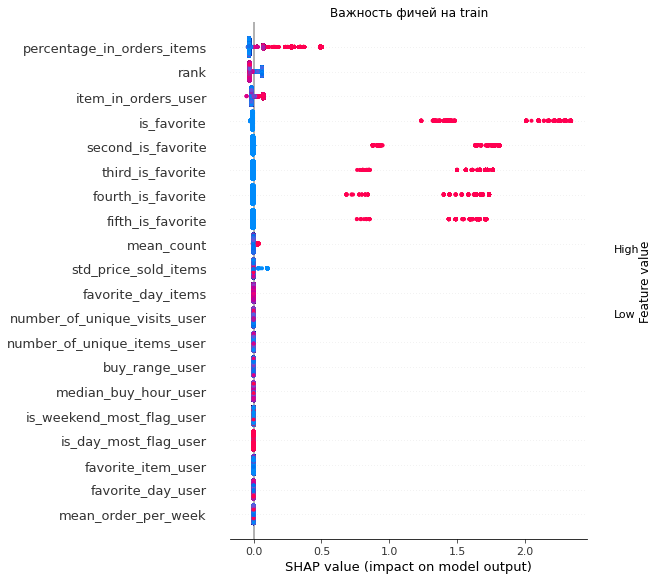

In [35]:
plt.title("Важность фичей на train")

shap.summary_plot(
    shap_values,
    X_train_subs
)

# del X_train_subs, shap_values, y_train_subs, expected_value

## Оценим метрики catboost модели 

In [36]:
ctb_test['user_id'] = ctb_test.user_id.astype(float)
test_feat = ctb_test.merge(users[user_col].drop_duplicates(),
                           on=['user_id'],
                           how='left')\
                    .merge(items[item_col].drop_duplicates(),
                               on=['item_id'],
                               how='left')

del ctb_test
test_feat.head()

,user_id,item_id,rank,target,median_total_cost_user,mean_total_cost_user,std_total_cost_user_x,median_price_sold_user,mean_price_sold_hist_user,std_price_sold_user,the_most_expensive_purchase_user,the_most_expensive_user,favorite_day_user,favorite_item_user,is_day_most_flag_user,is_weekend_most_flag_user,median_buy_hour_user,buy_range_user,number_of_unique_items_user,number_of_unique_visits_user,item_in_orders_user,mean_order_per_week,second_favorite_item_user,third_favorite_item_user,fourth_favorite_item_user,fifth_favorite_item_user,zero_price_orders,favorite_day_items,is_day_most_flag_items,std_total_cost_user_y,median_price_sold_items,mean_price_sold_hist_items,std_price_sold_items,median_amout_items,mean_amout_items,max_amout_items,range_amout_items,percentage_in_orders_items,is_weekend_most_flag_items,item_cost_defference_from_median,median_buy_hour_items,price_s_mean_items,price_s_median_items,item_bought_count_items,price_s_max_min,mean_count,zero_price_sold_count
0,95980454.0,204335325.0,108,0,69.750,83.8125,65.756943,49.6875,60.84375,43.069454,509.339996,341.989990,0,202803899,1.0,0.0,15.0,332.100006,104,8,137,19.578125,202796060,203422957,203431923,203407637,0.0,5,1.0,104.636276,29.984375,30.18750,2.851562,2.000000,2.000000,24.00000,23.000000,0.001176,0.0,-74.62500,13.0,30.18750,29.984375,272,26.00000,1.739258,0.0
1,94788839.0,202820273.0,58,0,81.875,109.8125,110.629547,77.4375,98.06250,100.851845,839.989990,839.989990,4,202807008,1.0,1.0,15.0,830.659973,90,4,98,32.656250,210734517,203035628,204061773,202807008,0.0,4,1.0,15.840068,58.000000,59.62500,9.039062,0.397949,0.397949,3.03125,3.011719,0.008904,0.0,-46.65625,13.0,59.62500,58.000000,2059,24.31250,1.086914,0.0
2,94701059.0,202992039.0,3,0,85.000,112.6250,95.294380,68.9375,97.31250,78.268509,548.900024,385.489990,5,202953789,1.0,1.0,14.0,376.179993,165,10,226,56.500000,203396813,204201617,204098355,202872237,0.0,0,1.0,88.205734,50.000000,48.87500,5.468750,2.000000,2.000000,12.00000,11.000000,0.000869,0.0,-54.65625,13.0,48.87500,50.000000,201,91.06250,1.032227,0.0
3,94691054.0,202797680.0,104,0,213.000,280.7500,247.127975,106.5000,171.87500,186.658966,1599.000000,1599.000000,2,203454152,1.0,0.0,11.0,1586.104980,133,12,203,33.843750,204097443,202820148,203566439,202791010,0.0,4,1.0,82.804428,59.875000,66.37500,14.046875,1.000000,1.000000,12.00000,11.000000,0.003220,0.0,-44.75000,13.0,66.37500,59.875000,745,12.65625,2.044922,0.0
4,95175395.0,203207194.0,36,0,242.750,443.5000,550.616272,54.3750,108.93750,137.404327,2552.797119,779.890015,1,202820148,1.0,0.0,9.0,769.000000,35,4,48,12.000000,203370019,213855465,203095154,203404725,0.0,3,1.0,103.903633,34.687500,40.90625,12.359375,2.000000,2.000000,16.00000,15.000000,0.003237,0.0,-69.93750,13.0,40.90625,34.687500,749,136.00000,0.328613,0.0


In [37]:
# fillna for catboost with the most frequent value 
test_feat = test_feat.fillna(X_train.mode().iloc[0])
test_feat['is_favorite'] = abs(test_feat['favorite_item_user'] - test_feat['item_id'])==0
test_feat['second_is_favorite'] = abs(test_feat['second_favorite_item_user'] - test_feat['item_id']) == 0
test_feat['third_is_favorite'] = abs(test_feat['third_favorite_item_user'] - test_feat['item_id']) == 0
test_feat['fourth_is_favorite'] = abs(test_feat['fourth_favorite_item_user'] - test_feat['item_id']) == 0
test_feat['fifth_is_favorite'] = abs(test_feat['fifth_favorite_item_user'] - test_feat['item_id']) == 0

In [38]:
X_test, y_test = test_feat.drop(drop_col + target_col, axis=1), test_feat['target']
# del test_feat

In [39]:
gc.collect()
X_test.head()

,rank,median_total_cost_user,mean_total_cost_user,std_total_cost_user_x,median_price_sold_user,mean_price_sold_hist_user,std_price_sold_user,the_most_expensive_purchase_user,the_most_expensive_user,favorite_day_user,favorite_item_user,is_day_most_flag_user,is_weekend_most_flag_user,median_buy_hour_user,buy_range_user,number_of_unique_items_user,number_of_unique_visits_user,item_in_orders_user,mean_order_per_week,second_favorite_item_user,third_favorite_item_user,fourth_favorite_item_user,fifth_favorite_item_user,zero_price_orders,favorite_day_items,is_day_most_flag_items,std_total_cost_user_y,median_price_sold_items,mean_price_sold_hist_items,std_price_sold_items,median_amout_items,mean_amout_items,max_amout_items,range_amout_items,percentage_in_orders_items,is_weekend_most_flag_items,item_cost_defference_from_median,median_buy_hour_items,price_s_mean_items,price_s_median_items,item_bought_count_items,price_s_max_min,mean_count,zero_price_sold_count,is_favorite,second_is_favorite,third_is_favorite,fourth_is_favorite,fifth_is_favorite
0,108,69.750,83.8125,65.756943,49.6875,60.84375,43.069454,509.339996,341.989990,0,202803899,1.0,0.0,15.0,332.100006,104,8,137,19.578125,202796060,203422957,203431923,203407637,0.0,5,1.0,104.636276,29.984375,30.18750,2.851562,2.000000,2.000000,24.00000,23.000000,0.001176,0.0,-74.62500,13.0,30.18750,29.984375,272,26.00000,1.739258,0.0,False,False,False,False,False
1,58,81.875,109.8125,110.629547,77.4375,98.06250,100.851845,839.989990,839.989990,4,202807008,1.0,1.0,15.0,830.659973,90,4,98,32.656250,210734517,203035628,204061773,202807008,0.0,4,1.0,15.840068,58.000000,59.62500,9.039062,0.397949,0.397949,3.03125,3.011719,0.008904,0.0,-46.65625,13.0,59.62500,58.000000,2059,24.31250,1.086914,0.0,False,False,False,False,False
2,3,85.000,112.6250,95.294380,68.9375,97.31250,78.268509,548.900024,385.489990,5,202953789,1.0,1.0,14.0,376.179993,165,10,226,56.500000,203396813,204201617,204098355,202872237,0.0,0,1.0,88.205734,50.000000,48.87500,5.468750,2.000000,2.000000,12.00000,11.000000,0.000869,0.0,-54.65625,13.0,48.87500,50.000000,201,91.06250,1.032227,0.0,False,False,False,False,False
3,104,213.000,280.7500,247.127975,106.5000,171.87500,186.658966,1599.000000,1599.000000,2,203454152,1.0,0.0,11.0,1586.104980,133,12,203,33.843750,204097443,202820148,203566439,202791010,0.0,4,1.0,82.804428,59.875000,66.37500,14.046875,1.000000,1.000000,12.00000,11.000000,0.003220,0.0,-44.75000,13.0,66.37500,59.875000,745,12.65625,2.044922,0.0,False,False,False,False,False
4,36,242.750,443.5000,550.616272,54.3750,108.93750,137.404327,2552.797119,779.890015,1,202820148,1.0,0.0,9.0,769.000000,35,4,48,12.000000,203370019,213855465,203095154,203404725,0.0,3,1.0,103.903633,34.687500,40.90625,12.359375,2.000000,2.000000,16.00000,15.000000,0.003237,0.0,-69.93750,13.0,40.90625,34.687500,749,136.00000,0.328613,0.0,False,False,False,False,False


In [40]:
y_pred = ctb_model.predict_proba(X_test)
del X_test

In [41]:
from sklearn.metrics import roc_auc_score

f"ROC AUC score = {roc_auc_score(y_test, y_pred[:, 1]):.2f}"
del y_test, y_pred

# Метрики качества на глобальном test

- Формируем рекомендации отдельно моделью 1 этапа - LightFM
- Отдельно двухэтапной моделью LightFM + Catboost 
- Сравниваем

## 1) Метрики качества LightFM

In [42]:
gc.collect()
# test_ids = pd.read_csv('../input/sbermarket-competition-intel/test_ids.csv')
# test_ids.head(3)

42

In [43]:
# оставляем только теплых пользователей
test = test[test['user_id'].isin(lfm_train['user_id'].unique())]

test.drop('completed_at', inplace=True, axis=1)
lfm_train.drop('completed_at', inplace=True, axis=1)
lfm_train.head()

,Unnamed: 0,user_id,item_id
0,0,94578442,202795926
1,1,94578442,202801709
2,2,94578442,202806979
3,3,94578442,202806998
4,4,94578442,202807303


In [44]:
# кол-во кандидатов берем больше, чем для обучения
# чтобы катбусту было, что ранжировать
top_N = 30

lfm_prediction = pd.DataFrame({
    'user_id': test['user_id'].unique()
})

In [45]:
lfm_train.head()

,Unnamed: 0,user_id,item_id
0,0,94578442,202795926
1,1,94578442,202801709
2,2,94578442,202806979
3,3,94578442,202806998
4,4,94578442,202807303


In [46]:
lfm_train.drop_duplicates(inplace=True)
lfm_train.head()
lfm_train.shape

(2656340, 3)

In [47]:
del items
gc.collect()

105

In [48]:
def get_known_items():
    
    global lfm_train
    tmp = lfm_train.groupby('user_id')['item_id'].apply(list)
    del lfm_train
    known_items = tmp.to_dict()
    del tmp
    
    return known_items

known_items = get_known_items()

In [49]:
mapper = generate_lightfm_recs_mapper(
    lfm_model, 
    item_ids=all_cols, 
    known_items=known_items,
    N=top_N,
    user_features=None, 
    item_features=None, 
    user_mapping=lightfm_mapping['users_mapping'],
    item_inv_mapping=lightfm_mapping['items_inv_mapping'],
    num_threads=20
)

del lightfm_mapping

In [50]:
from tqdm import tqdm
tqdm.pandas()  # <- added this line

In [51]:
# lfm_prediction['item_id'] = lfm_prediction['user_id'].map(mapper)
lfm_prediction['item_id'] = lfm_prediction['user_id'].progress_map(mapper)
lfm_prediction = lfm_prediction.explode('item_id').reset_index(drop=True)
lfm_prediction['rank'] = lfm_prediction.groupby('user_id').cumcount() + 1 

100%|██████████| 3608/3608 [00:31<00:00, 114.57it/s]


In [52]:
lfm_prediction.to_csv('lfm_prediction.csv', index=False)

### `1 этап LightFM`: Метрики Precision@k, Recall@k, MAP@k, MRR

k = 1, .., 10

In [53]:
def compute_metrics(df_true, df_pred, top_N, rank_col='rank'):
    result = {}
    test_recs = df_true.set_index(['user_id', 'item_id']).join(df_pred.set_index(['user_id', 'item_id']))
    test_recs = test_recs.sort_values(by=['user_id', rank_col])

    test_recs['users_item_count'] = test_recs.groupby(level='user_id')[rank_col].transform(np.size)
    test_recs['reciprocal_rank'] = (1 / test_recs[rank_col]).fillna(0)
    test_recs['cumulative_rank'] = test_recs.groupby(level='user_id').cumcount() + 1
    test_recs['cumulative_rank'] = test_recs['cumulative_rank'] / test_recs[rank_col]
    
    print('Прошел первую часть!')
    
    users_count = test_recs.index.get_level_values('user_id').nunique()
    for k in range(1, top_N + 1):
        hit_k = f'hit@{k}'
        test_recs[hit_k] = test_recs[rank_col] <= k
        result[f'Precision@{k}'] = (test_recs[hit_k] / k).sum() / users_count
        result[f'Recall@{k}'] = (test_recs[hit_k] / test_recs['users_item_count']).sum() / users_count

    result[f'MAP@{top_N}'] = (test_recs["cumulative_rank"] / test_recs["users_item_count"]).sum() / users_count
    result[f'MRR'] = test_recs.groupby(level='user_id')['reciprocal_rank'].max().mean()
    return pd.Series(result)

In [54]:
# from tools import compute_metrics

lfm_metrics = compute_metrics(test[['user_id', 'item_id']],
                              lfm_prediction, 
                              top_N=20)
# lfm_metrics

Прошел первую часть!


In [55]:
items = get_item()
users = get_user()

52472
Memory usage of dataframe is 8.11 MB
Memory usage after optimization is: 3.00 MB
Decreased by 63.0%
63925
Memory usage of dataframe is 11.34 MB
Memory usage after optimization is: 5.00 MB
Decreased by 55.9%


## 2) Метрики качества двухэтапной модели: `LightFM` + `Catboost`

In [56]:
users[user_col].head()

,user_id,median_total_cost_user,mean_total_cost_user,std_total_cost_user,median_price_sold_user,mean_price_sold_hist_user,std_price_sold_user,the_most_expensive_purchase_user,the_most_expensive_user,favorite_day_user,favorite_item_user,is_day_most_flag_user,is_weekend_most_flag_user,median_buy_hour_user,buy_range_user,number_of_unique_items_user,number_of_unique_visits_user,item_in_orders_user,mean_order_per_week,second_favorite_item_user,third_favorite_item_user,fourth_favorite_item_user,fifth_favorite_item_user,zero_price_orders
0,94578442,134.0000,152.7500,100.008995,95.0000,128.3750,109.095589,393.989990,419.993988,6,202801709,1.0,1.0,17.0,392.933990,31,3,37,12.335938,202979560,203438161,203529348,203457496,0.0
1,94578475,96.9375,142.5000,159.480331,71.4375,118.3750,145.519043,848.989990,848.989990,5,202791192,1.0,1.0,15.0,820.494995,38,2,38,19.000000,203083929,203011581,203566429,202880254,0.0
2,94578533,74.0000,104.8125,100.222633,54.0000,78.9375,75.936279,599.979980,337.989990,4,202807066,1.0,0.0,12.0,335.500000,54,4,62,20.671875,202864758,202915968,203586026,202872237,0.0
3,94578595,127.5000,216.6250,296.156799,100.0000,127.0000,78.101074,1803.732056,363.987000,1,202799674,1.0,0.0,12.0,350.041992,36,3,43,14.335938,202807477,202799674,202801849,202806977,0.0
4,94578656,69.9375,93.8750,70.958069,64.1250,84.1250,63.949863,335.489990,335.489990,1,202838754,1.0,0.0,16.0,321.644989,63,6,80,16.000000,202872237,202820148,202910396,202807411,0.0


In [57]:
# # users.user_id.nunique(), lfm_ctb_prediction.item_id.nunique()
# users[user_col].drop_duplicates().shape, users.user_id.nunique()

In [58]:
# lfm_ctb_prediction['user_id'] = lfm_ctb_prediction.user_id.astype(float).astype(int).astype(str)
# users['user_id'] = users.user_id.astype(float).astype(int).astype(str)

# print(lfm_ctb_prediction.shape)
# lfm_ctb_prediction[['user_id', 'item_id']].drop_duplicates().merge(users[user_col].drop_duplicates(), on='user_id', how='left')

In [59]:
lfm_ctb_prediction = lfm_prediction.copy()
print(lfm_ctb_prediction.shape)
# фичи для теста
score_feat = (lfm_ctb_prediction.merge(users[user_col].drop_duplicates(),on=['user_id'], how='left')
                                .merge(items[item_col].drop_duplicates(), on=['item_id'], how='left'))

# fillna for catboost with the most frequent value 
print(score_feat.shape)
score_feat = score_feat.fillna(X_train.mode().iloc[0])
print(score_feat.shape)

score_feat['is_favorite'] = abs(score_feat['favorite_item_user'] - score_feat['item_id'])==0
score_feat['second_is_favorite'] = abs(score_feat['second_favorite_item_user'] - score_feat['item_id']) == 0
score_feat['third_is_favorite'] = abs(score_feat['third_favorite_item_user'] - score_feat['item_id']) == 0
score_feat['fourth_is_favorite'] = abs(score_feat['fourth_favorite_item_user'] - score_feat['item_id']) == 0
score_feat['fifth_is_favorite'] = abs(score_feat['fifth_favorite_item_user'] - score_feat['item_id']) == 0

print(score_feat.shape)
# del X_train, users, items

(108240, 3)
(108240, 46)
(108240, 46)
(108240, 51)


In [60]:
score_feat.head()

,user_id,item_id,rank,median_total_cost_user,mean_total_cost_user,std_total_cost_user_x,median_price_sold_user,mean_price_sold_hist_user,std_price_sold_user,the_most_expensive_purchase_user,the_most_expensive_user,favorite_day_user,favorite_item_user,is_day_most_flag_user,is_weekend_most_flag_user,median_buy_hour_user,buy_range_user,number_of_unique_items_user,number_of_unique_visits_user,item_in_orders_user,mean_order_per_week,second_favorite_item_user,third_favorite_item_user,fourth_favorite_item_user,fifth_favorite_item_user,zero_price_orders,favorite_day_items,is_day_most_flag_items,std_total_cost_user_y,median_price_sold_items,mean_price_sold_hist_items,std_price_sold_items,median_amout_items,mean_amout_items,max_amout_items,range_amout_items,percentage_in_orders_items,is_weekend_most_flag_items,item_cost_defference_from_median,median_buy_hour_items,price_s_mean_items,price_s_median_items,item_bought_count_items,price_s_max_min,mean_count,zero_price_sold_count,is_favorite,second_is_favorite,third_is_favorite,fourth_is_favorite,fifth_is_favorite
0,94579825,203573262.0,1,122.25,136.625,72.001274,84.5,107.875,59.806084,442.980011,285.98999,4,202807062,1.0,1.0,17.0,259.809998,57,6,65,13.0,204065949,204084023,202807332,202978011,0.0,0,1.0,128.405899,100.000000,93.125000,11.257812,1.000000,1.000000,15.000000,14.000000,0.000718,0.0,-4.652344,13.0,93.125000,100.000000,166,148.875000,1.075195,0.0,False,False,False,False,False
1,94579825,202809628.0,2,122.25,136.625,72.001274,84.5,107.875,59.806084,442.980011,285.98999,4,202807062,1.0,1.0,17.0,259.809998,57,6,65,13.0,204065949,204084023,202807332,202978011,0.0,5,1.0,36.690964,12.945312,15.093750,8.585938,0.941895,0.941895,25.062500,25.062500,0.117798,0.0,-91.687500,13.0,15.093750,12.945312,27245,83.375000,1.084961,0.0,False,False,False,False,False
2,94579825,202872237.0,3,122.25,136.625,72.001274,84.5,107.875,59.806084,442.980011,285.98999,4,202807062,1.0,1.0,17.0,259.809998,57,6,65,13.0,204065949,204084023,202807332,202978011,0.0,4,1.0,206.982651,17.437500,22.796875,21.515625,1.963867,1.963867,25.546875,25.546875,0.180054,0.0,-87.187500,13.0,22.796875,17.437500,41658,29.984375,1.775391,0.0,False,False,False,False,False
3,94579825,202820148.0,4,122.25,136.625,72.001274,84.5,107.875,59.806084,442.980011,285.98999,4,202807062,1.0,1.0,17.0,259.809998,57,6,65,13.0,204065949,204084023,202807332,202978011,0.0,4,1.0,56.507679,55.875000,59.781250,16.390625,1.000000,1.000000,11.507812,11.507812,0.284668,0.0,-48.750000,13.0,59.781250,55.875000,65840,49.250000,1.227539,0.0,False,False,False,False,False
4,94579825,203566372.0,5,122.25,136.625,72.001274,84.5,107.875,59.806084,442.980011,285.98999,4,202807062,1.0,1.0,17.0,259.809998,57,6,65,13.0,204065949,204084023,202807332,202978011,0.0,4,1.0,46.562992,54.875000,61.937500,12.828125,1.000000,1.000000,24.000000,23.000000,0.042908,0.0,-49.750000,13.0,61.937500,54.875000,9924,95.000000,1.094727,0.0,False,False,False,False,False


In [61]:
# catboost predict_proba
ctb_prediction = ctb_model.predict_proba(score_feat.drop(drop_col, axis=1, errors='ignore'))
del ctb_model, score_feat

lfm_ctb_prediction['ctb_pred'] = ctb_prediction[:, 1]
lfm_ctb_prediction.head(3)

,user_id,item_id,rank,ctb_pred
0,94579825,203573262.0,1,0.165209
1,94579825,202809628.0,2,0.249704
2,94579825,202872237.0,3,0.249704


In [62]:
lfm_prediction.sort_values(
    by=['user_id'], ascending=[True]).head(10)

,user_id,item_id,rank
0,94579825,203573262.0,1
29,94579825,203059303.0,30
28,94579825,203580835.0,29
27,94579825,203442947.0,28
26,94579825,202820144.0,27
25,94579825,202807411.0,26
24,94579825,202862432.0,25
23,94579825,202818687.0,24
22,94579825,204147167.0,23
20,94579825,202808447.0,21


In [63]:
del ctb_prediction
del lfm_prediction
gc.collect()

84

### Проставляем итоговый ранк двухэтапной модели

In [64]:
# сортируем по скору внутри одного пользователя и проставляем новый ранг
lfm_ctb_prediction = lfm_ctb_prediction.sort_values(
    by=['user_id', 'ctb_pred'], ascending=[True, False])
lfm_ctb_prediction['rank_ctb'] = lfm_ctb_prediction.groupby('user_id').cumcount() + 1

In [65]:
lfm_ctb_prediction.head(10)

,user_id,item_id,rank,ctb_pred,rank_ctb
8,94579825,202807062.0,9,0.664836,1
6,94579825,204065949.0,7,0.535449,2
1,94579825,202809628.0,2,0.249704,3
2,94579825,202872237.0,3,0.249704,4
3,94579825,202820148.0,4,0.249704,5
24,94579825,202862432.0,25,0.211889,6
29,94579825,203059303.0,30,0.211889,7
15,94579825,202807362.0,16,0.184378,8
4,94579825,203566372.0,5,0.180020,9
7,94579825,202843988.0,8,0.180020,10


In [66]:
# интересно сравнить ранки 1 этапа lightfm и двухэтапной модели
pd.crosstab(lfm_ctb_prediction[lfm_ctb_prediction['rank'] <= 25]['rank'], 
            lfm_ctb_prediction[lfm_ctb_prediction['rank_ctb'] <= 25]['rank_ctb'])\
    .style.background_gradient(cmap='spring')

rank_ctb,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
rank,,,,,,,,,,,,,,,,,,,,,,,,,
1,1158,623,275,177,153,132,131,135,109,121,101,103,92,91,74,37,33,27,20,9,3,1,3,0,0
2,438,811,475,230,176,159,158,153,148,131,131,107,116,93,91,69,42,29,21,17,7,5,1,0,0
3,247,367,297,228,233,279,305,239,201,168,144,154,140,139,126,123,83,59,36,24,9,6,0,1,0
4,174,248,238,186,228,274,301,306,246,212,171,164,159,149,142,123,109,64,44,31,21,11,4,2,0
5,138,151,196,177,187,214,280,329,299,224,211,179,167,180,156,150,126,100,64,41,22,14,2,1,0
6,130,135,188,144,177,169,211,267,325,279,220,194,178,190,178,148,162,126,77,56,28,18,5,2,1
7,109,108,168,160,172,151,177,235,252,297,242,235,197,176,212,186,158,148,91,52,54,16,11,1,0
8,110,96,126,161,163,125,154,163,214,254,298,231,220,198,214,216,168,173,130,93,42,37,16,4,2
9,80,83,140,165,138,160,124,147,168,211,248,268,216,222,199,230,216,167,170,114,68,39,28,7,0


### `1+2 этапы LightFM + Сatboost`: Метрики 

k = 1, .., 10

In [67]:
print(test.shape)
test.drop_duplicates(inplace=True)
gc.collect()
print(test.shape)
test.drop('product_quantity', axis=1, inplace=True)
test.head()

(79222, 4)
(79222, 4)


,Unnamed: 0,user_id,item_id
1254,1254,94579825,202807062
1258,1258,94579825,202808560
1262,1262,94579825,202868347
1263,1263,94579825,202907806
1265,1265,94579825,202978011


In [68]:
del known_items 
gc.collect()

21

In [69]:
model_2step_metrics = compute_metrics(test[['user_id', 'item_id']],
                                       lfm_ctb_prediction, 
                                       top_N=20, 
                                       rank_col='rank_ctb')
del lfm_ctb_prediction, test
model_2step_metrics

Прошел первую часть!


Precision@1     0.413248
Recall@1        0.020599
Precision@2     0.301275
Recall@2        0.029888
Precision@3     0.240299
Recall@3        0.035353
Precision@4     0.202813
Recall@4        0.039458
Precision@5     0.175721
Recall@5        0.042566
Precision@6     0.157151
Recall@6        0.045558
Precision@7     0.142461
Recall@7        0.047976
Precision@8     0.131409
Recall@8        0.050601
Precision@9     0.122721
Recall@9        0.052995
Precision@10    0.115687
Recall@10       0.055490
Precision@11    0.109706
Recall@11       0.057756
Precision@12    0.105067
Recall@12       0.060180
Precision@13    0.100887
Recall@13       0.062602
Precision@14    0.096947
Recall@14       0.064644
Precision@15    0.093422
Recall@15       0.066589
Precision@16    0.090199
Recall@16       0.068413
Precision@17    0.087371
Recall@17       0.070460
Precision@18    0.084827
Recall@18       0.072353
Precision@19    0.082288
Recall@19       0.074033
Precision@20    0.080225
Recall@20       0.075951


## 🧐 Сравнение метрик

In [70]:
gc.collect()

21

In [71]:
df_metrics = pd.concat([
    pd.DataFrame(lfm_metrics).transpose(),
    pd.DataFrame(model_2step_metrics).transpose()
])

df_metrics.index = ['lightfm', 'model_2step']

df_metrics

,Precision@1,Recall@1,Precision@2,Recall@2,Precision@3,Recall@3,Precision@4,Recall@4,Precision@5,Recall@5,Precision@6,Recall@6,Precision@7,Recall@7,Precision@8,Recall@8,Precision@9,Recall@9,Precision@10,Recall@10,Precision@11,Recall@11,Precision@12,Recall@12,Precision@13,Recall@13,Precision@14,Recall@14,Precision@15,Recall@15,Precision@16,Recall@16,Precision@17,Recall@17,Precision@18,Recall@18,Precision@19,Recall@19,Precision@20,Recall@20,MAP@20,MRR
lightfm,0.179601,0.008675,0.148559,0.014393,0.132206,0.019085,0.120427,0.023090,0.110809,0.026641,0.106199,0.030594,0.100135,0.033546,0.096487,0.036793,0.093404,0.040061,0.090382,0.04300,0.087205,0.045512,0.085042,0.048405,0.083532,0.051407,0.081090,0.053776,0.079712,0.056604,0.078194,0.059186,0.076823,0.061859,0.076019,0.064827,0.074484,0.066995,0.073032,0.069060,0.027081,0.300141
model_2step,0.413248,0.020599,0.301275,0.029888,0.240299,0.035353,0.202813,0.039458,0.175721,0.042566,0.157151,0.045558,0.142461,0.047976,0.131409,0.050601,0.122721,0.052995,0.115687,0.05549,0.109706,0.057756,0.105067,0.060180,0.100887,0.062602,0.096947,0.064644,0.093422,0.066589,0.090199,0.068413,0.087371,0.070460,0.084827,0.072353,0.082288,0.074033,0.080225,0.075951,0.043666,0.493182


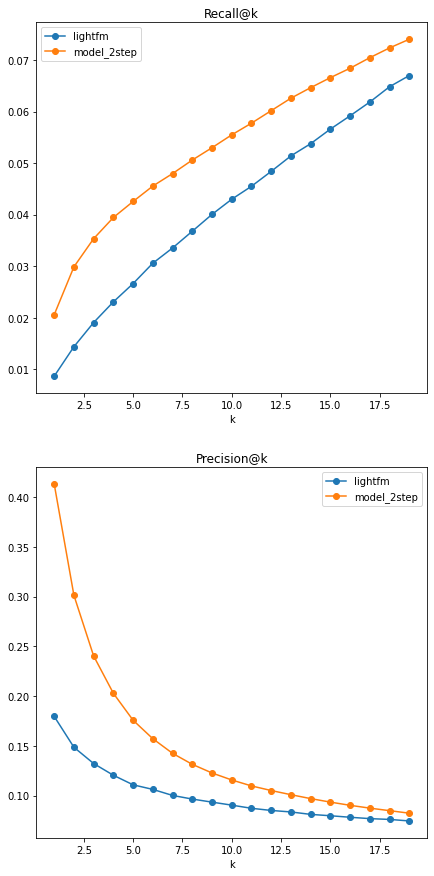

In [72]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(7, 15))

for indx, metric in enumerate([f'Recall@', f'Precision@']):
    for model in df_metrics.index:
        axes[indx].plot(range(1, 20), 
                        df_metrics.loc[model][[metric+f'{k}' for k in range(1, 20)]].values,
                        label=model, marker='o')
        axes[indx].legend()
        axes[indx].set_title(f'{metric}k')
        axes[indx].set_xlabel('k')

# Что дальше:
    
- подбирать соотношение train и test 
- кандидаты от нескольких моделей
- другие варианты сбора обучающей выборки для бустинга
- генерация признаков для бустинга
- валидировать итоговые метрики как тест = 1 день со сдвигом в 1 день и усреднять значения метрик за 7 дней

